# Data merging and prepping for credit default analysis

This notebook is a walkthrough of the script credit_risk_datagen.py used for generating data for credit default prediction.
The actual models can be found on the Credit Default Prediction with ML notebook.

We will begin by importing relevant libraries, importing and joining the datasets and exploring some missingness of the data

In [122]:
import pandas as pd
pd.options.mode.chained_assignment = None
import pickle
import numpy as np

In [123]:
trans = pd.read_csv('bk/data_berka/trans.asc',sep=';')
client = pd.read_csv('bk/data_berka/client.asc',sep=';')
account = pd.read_csv('bk/data_berka/account.asc',sep=';')
disp = pd.read_csv('bk/data_berka/disp.asc',sep=';')
order = pd.read_csv('bk/data_berka/order.asc',sep=';')
loan = pd.read_csv('bk/data_berka/loan.asc',sep=';')
card = pd.read_csv('bk/data_berka/card.asc',sep=';')
district = pd.read_csv('bk/data_berka/district.asc',sep=';')

### Reading and merging the loan and account -related datasets
We merge the static datasets and explore proportional missingness in the full data.

In [124]:
df = pd.merge(loan, account,on='account_id', suffixes=['_loan','_acnt'], how='outer')
df = pd.merge(df, disp, on='account_id', how='outer')
df = pd.merge(df, client, on='client_id', how='outer', suffixes = ['_clnt','_acnt'])
df = pd.merge(df, district, left_on='district_id_clnt', right_on='A1', how='outer')
df = pd.merge(df, card, on='disp_id', how='outer', suffixes=['', '_card'])

In [125]:
print(np.sum(df.isna())/len(df))
print('\nThere are {} loans in the data.'.format(len(df.loan_id.unique())))

loan_id             0.845968
account_id          0.000000
date_loan           0.845968
amount              0.845968
duration            0.845968
payments            0.845968
status              0.845968
district_id_clnt    0.000000
frequency           0.000000
date_acnt           0.000000
disp_id             0.000000
client_id           0.000000
type                0.000000
birth_number        0.000000
district_id_acnt    0.000000
A1                  0.000000
A2                  0.000000
A3                  0.000000
A4                  0.000000
A5                  0.000000
A6                  0.000000
A7                  0.000000
A8                  0.000000
A9                  0.000000
A10                 0.000000
A11                 0.000000
A12                 0.000000
A13                 0.000000
A14                 0.000000
A15                 0.000000
A16                 0.000000
card_id             0.833861
type_card           0.833861
issued              0.833861
dtype: float64

There are relatively few loans available in the datasets, and most accounts do not have a loan associated with them.
The missingness of credit card data is no issue, as the type and issue date of cards are likely not relevant to the problem.



### Feature generation for loans

We first drop observations on users that do not have a loan associated in any of the accounts they participate in.

We also drop some irrelevant columns. Most of the identification was only necessary for joining the data, so they are dropped. 
There are only 5 junior and 3 gold cards in the data so the card type is dropped as well.

We then encode features into formats suitable for machine learning.

The demographic data is available only as static values measured after some of the loans in the data are already issued. Because ex-ante values are not available, we make the assumption that  the demographics do not drastically change across years. However, if the demographics turn out to be important in predicting credit defaults, this problem should be readdressed.

In [126]:
loans = df[~df.loan_id.isna()]

# create a table that we will later use for merging
loan_dates = loans[['account_id','loan_id','date_loan']]
#translate loan date to datetime format
loan_dates.date_loan = pd.to_datetime(loan_dates.date_loan, format='%y%m%d')

#drop unnecessary columns
loans.drop(['account_id','district_id_acnt','district_id_clnt', 'disp_id',
            'client_id', 'card_id', 'type_card'], axis=1, inplace=True)



#create dummy for whether the loan completed successfully
loans['target'] = (loans.status == 'B').astype(int) + (loans.status == 'D').astype(int)

#convert date columns to datetime
loans['date_loan'] = pd.to_datetime(loans.date_loan, format='%y%m%d')
loans['issued'] = pd.to_datetime(loans.issued.str[:6])
loans['date_acnt'] = pd.to_datetime(loans.date_acnt, format='%y%m%d')

#find gender (encoded into the birthnumber) and convert birthdate into datetime
loans['gender'] = (loans.birth_number % 10000 > 5000).astype(int)
loans['birthdate'] = loans.birth_number - 5000 * loans.gender + 19000000
loans['birthdate'] = pd.to_datetime(loans.birthdate, format='%Y%m%d')

#find the age of applicant and the account at the time of loan issuance
loans['appl_age'] = (loans.date_loan - loans.birthdate).dt.days / 365.25
loans['accnt_age'] = (loans.date_loan - loans.date_acnt).dt.days / 365.25



#create dummy for whether the account has an associated card at the time of loan issuance
loans['issued'] = (loans.issued < loans.date_loan).astype(int)

#create dummies for the frequency of statement issuance and the account type
loans = pd.get_dummies(loans, columns=['frequency', 'type'], drop_first=True)


# select unemployment and crime from the demographic statistics.
loans['A13'] = np.select([loans.date_loan.dt.year > 1996,
                             loans.date_loan.dt.year < 1997],
                            [loans.A13, loans.A12])

loans['A12'] = np.select([loans.date_loan.dt.year > 1996, loans.date_loan.dt.year < 1997],
          [loans.A16, loans.A15])

# convert the columns to numeric values and scale the crime numbers for population
loans['A13'] = pd.to_numeric(loans.A13, errors='coerce')
loans['A12'] = pd.to_numeric(loans.A12, errors='coerce') / loans.A4
loans['A14'] = loans.A14 / loans.A4 * 100



#finally, aggregate to loan-level from client-level data
loans = loans.groupby('loan_id').agg('mean')
#create dummy for loans, where the account has multiple users
loans['multi'] = np.select([loans.type_OWNER < 1], [1], 0)

#drop unnecessary columns
loans.drop(['birth_number','type_OWNER','A16'], axis=1, inplace=True)

In [127]:
loans.columns = ['amount', 'duration', 'payments', 'A1', 'A4', 'A5', 'A6', 'A7', 'A8',
       'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'issued', 'target', 'gender',
       'appl_age', 'accnt_age', 'frequency_trans',
       'frequency_weekly', 'multi']

In [128]:
print('There are {} loans in the data.\n'.format(len(loans)))
print('Missing data:')
print(np.sum(loans.isna()), '\n')
print(loans.loc[loans.A13.isna(),['A1', 'A12','A13']])

There are 682 loans in the data.

Missing data:
amount              0
duration            0
payments            0
A1                  0
A4                  0
A5                  0
A6                  0
A7                  0
A8                  0
A9                  0
A10                 0
A11                 0
A12                 3
A13                 3
A14                 0
issued              0
target              0
gender              0
appl_age            0
accnt_age           0
frequency_trans     0
frequency_weekly    0
multi               0
dtype: int64 

           A1  A12  A13
loan_id                
5128.0   69.0  NaN  NaN
5282.0   69.0  NaN  NaN
6613.0   69.0  NaN  NaN


The missing unemployment and crime data is from district with id 69. We will look at whether we have the data for the district available somewhere else and replace accordingly.

In [129]:
print(loans.loc[loans.A1==69,['A1', 'A12','A13']])
loans.loc[loans.A13.isna(),['A12','A13']] = loans.loc[5281,['A12','A13']].values
print(loans.loc[loans.A1==69,['A1', 'A12','A13']])
loans.drop('A1', axis=1, inplace=True)

           A1       A12   A13
loan_id                      
5128.0   69.0       NaN   NaN
5281.0   69.0  0.031713  7.01
5282.0   69.0       NaN   NaN
5868.0   69.0  0.031713  7.01
6436.0   69.0  0.031713  7.01
6613.0   69.0       NaN   NaN
6866.0   69.0  0.031713  7.01
7100.0   69.0  0.031713  7.01
           A1       A12   A13
loan_id                      
5128.0   69.0  0.031713  7.01
5281.0   69.0  0.031713  7.01
5282.0   69.0  0.031713  7.01
5868.0   69.0  0.031713  7.01
6436.0   69.0  0.031713  7.01
6613.0   69.0  0.031713  7.01
6866.0   69.0  0.031713  7.01
7100.0   69.0  0.031713  7.01


### Read in and merge transaction data

We are ready to work with the transaction data.

In [130]:
trans = pd.read_csv('bk/data_berka/trans.asc', sep=';')
trans_loans = pd.merge(loan_dates, trans, on='account_id', suffixes=['', '_trans'], how='left')
print('Total transactions: ', len(trans_loans))

Total transactions:  233627


Because we're interested in predicting bad loans, we should use transaction data from only prior to giving out the loan.
In order to work with the dates, we will first transform them to datetime format

In [131]:
trans_loans.date = pd.to_datetime(trans_loans.date, format='%y%m%d')

#filter to transactions prior to loan issuance
trans_loans = trans_loans[trans_loans.date < trans_loans.date_loan]

print('We end up with {} ex-ante transactions for our final data.'.format(len(trans_loans)))

We end up with 66762 ex-ante transactions for our final data.


### Explore missingness in the transaction data 

In [132]:
print(np.sum(trans.isna())/len(trans))

trans_id      0.000000
account_id    0.000000
date          0.000000
type          0.000000
operation     0.173351
amount        0.000000
balance       0.000000
k_symbol      0.456188
bank          0.741075
account       0.720360
dtype: float64


In [133]:
print(np.sum(trans_loans.isna())/len(trans_loans))

account_id    0.000000
loan_id       0.000000
date_loan     0.000000
trans_id      0.000000
date          0.000000
type          0.000000
operation     0.172883
amount        0.000000
balance       0.000000
k_symbol      0.582322
bank          0.815763
account       0.706180
dtype: float64


Bank and account columns report the bank and account of a partner in a transaction. As such, the specific bank and of a partner are likely not relevant and missingness should not be an issue.

Because we want to utilize the transactions for predicting credit defaults, transaction types are intuitively important. The operation and k_symbol columns describe the transaction type. We will explore the missing operation data further by examining, whethere there are cases where both operation and k_symbol are missing:

In [134]:
print('Percentage of cases where both operation and k_symbol are missing: ')
print(np.sum(trans.operation.isna() & trans.k_symbol.isna())/len(trans))
print('Percentage of cases where both operation and k_symbol are reported: ')
print(np.sum(~trans.operation.isna() & ~trans.k_symbol.isna())/len(trans))

print('Percentage of cases where both operation and k_symbol are missing: ')
print(np.sum(trans_loans.operation.isna() & trans_loans.k_symbol.isna())/len(trans))
print('Percentage of cases where both operation and k_symbol are reported: ')
print(np.sum(~trans_loans.operation.isna() & ~trans_loans.k_symbol.isna())/len(trans))

Percentage of cases where both operation and k_symbol are missing: 
0.0
Percentage of cases where both operation and k_symbol are reported: 
0.37046065586186006
Percentage of cases where both operation and k_symbol are missing: 
0.0
Percentage of cases where both operation and k_symbol are reported: 
0.01547163738261133


We see that, while operation and k_symbol are missing at times, there are no cases where neither one is present. Thus, missingness should be no issue.

Because missing data is not an issue and we do not need to use the transaction data to predict missing values, we can focus on the subset of the transactions data, where there are loans present.



## Aggregating transactions

We noe move on to aggregating the transactions data to loan-level.

First, we drop irrelevant columns and generate some dummy variables. Only transaction-related variables are kept.
Out of the transaction variables, the bank and account columns are likely not relevant and quite sparse, so they are dropped. 

In [135]:
trans_loans = trans_loans[['loan_id', 'date','date_loan', 'type', 'operation',
       'amount', 'balance', 'k_symbol']]

#drop transactions of payments for statements as they are the same price for all customers
#and very likely not of interest
trans_loans = trans_loans[trans_loans.k_symbol != 'SLUZBY']

#as the k_symbol and operation cover similar things, we combine them into one
#categorical variable that describes the operation type
trans_loans.k_symbol.fillna(trans_loans.operation, inplace=True)

print(trans_loans.k_symbol.value_counts())

#get dummies for operation
trans_loans = pd.get_dummies(trans_loans, columns=['k_symbol'], prefix='type')

#combine card and cash withdrawals to one
trans_loans['type_VYBER'] = trans_loans['type_VYBER KARTOU'] + trans_loans['type_VYBER']

#drop irrelevant columns and rename columns more intuitively
trans_loans.drop(['type','operation', 'type_VYBER KARTOU'], axis=1, inplace=True)
trans_loans.columns = ['loan_id', 'date', 'date_loan', 'amount_trans', 'balance', 'b_withdr',
       'insur', 'b_deposit', 'sanc', 'hhold',
       'interest', 'c_deposit', 'c_withdr']


VYBER            23623
VKLAD            11956
UROK             11542
SIPO              4878
PREVOD Z UCTU     3200
                  3082
POJISTNE          1311
VYBER KARTOU        98
SANKC. UROK         81
Name: k_symbol, dtype: int64


### Create aggregate time-series variables
We will create aggregate time-series' for the recent interest rate as measured by the rate transactions and for the amount of concurrent loan applicants (rolling mean of past 6 months.

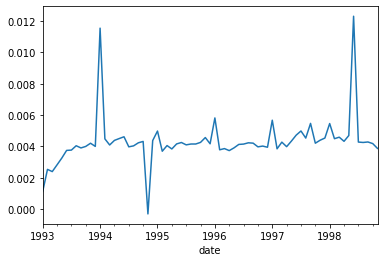

In [136]:
#create interest-rate variable for interest transactions
trans_loans['rate'] = (trans_loans.amount_trans * trans_loans.interest) / (trans_loans.balance - trans_loans.amount_trans)
rates = trans_loans[trans_loans.interest == 1].groupby('date').mean().rate
rates.plot.line()


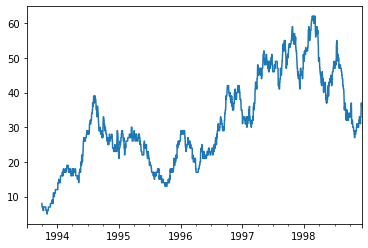

In [137]:
#create applicant variable as the rolling 90-day average of applicants
applicants = trans_loans.groupby('loan_id').first().date_loan.value_counts().sort_index()
applicants = applicants.resample('D').sum().rolling(90).sum()
applicants.plot.line()

We can now merge, the time-series variables with the loan data

In [141]:
#Merge time-series variables with static loan data
ts_data = loan_dates.sort_values('date_loan')
#merge rates
ts_data = pd.merge_asof(ts_data, rates, left_on='date_loan', right_index=True)
#merge amount of applicants
ts_data = pd.merge(ts_data, applicants, left_on='date_loan', right_index=True)

#drop trash and set index for joining
ts_data.drop(['date_loan','account_id','date_loan_x'], axis=1, inplace=True)
ts_data.columns=['loan_id', 'rate','applicants']
ts_data.set_index('loan_id', inplace=True)


loans = loans.join(ts_data)

,amount,duration,payments,A4,A5,A6,A7,A8,A9,A10,...,issued,target,gender,appl_age,accnt_age,frequency_trans,frequency_weekly,multi,rate,applicants
loan_id,,,,,,,,,,,,,,,,,,,,,
4959.0,80952.0,24.0,3373.0,1204953.0,0.0,0.0,0.0,1.0,1.0,100.0,...,0.0,0.0,0.5,51.078713,0.856947,0.0,0.0,1,0.003996,14.0
4961.0,30276.0,12.0,2523.0,103347.0,87.0,16.0,7.0,1.0,7.0,67.0,...,0.0,1.0,1.0,57.018480,1.062286,0.0,0.0,0,0.003858,23.0
4962.0,30276.0,12.0,2523.0,228848.0,15.0,40.0,18.0,2.0,6.0,57.2,...,0.0,0.0,0.0,35.827515,1.363450,0.0,0.0,0,0.004392,43.0
4967.0,318480.0,60.0,5308.0,70646.0,94.0,14.0,3.0,1.0,4.0,58.4,...,0.0,1.0,0.0,46.132786,1.155373,0.0,0.0,0,0.004280,32.0
4968.0,110736.0,48.0,2307.0,51428.0,50.0,11.0,3.0,1.0,4.0,52.7,...,0.0,0.0,1.0,58.217659,0.695414,0.0,1.0,0,0.004587,46.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7294.0,39168.0,24.0,1632.0,94725.0,38.0,28.0,1.0,3.0,6.0,63.4,...,0.0,0.0,1.0,19.594798,0.950034,0.0,0.0,0,0.004249,34.0
7295.0,280440.0,60.0,4674.0,387570.0,0.0,0.0,0.0,1.0,1.0,100.0,...,0.0,0.0,1.0,45.853525,1.697467,0.0,0.0,0,0.012311,50.0
7304.0,419880.0,60.0,6998.0,1204953.0,0.0,0.0,0.0,1.0,1.0,100.0,...,0.0,0.0,0.5,51.279945,0.427105,0.0,1.0,1,0.004150,16.0


### Compute aggregations and combine
We first aggregate the transaction data to loan-level.
Then we merge with the static loan data and the time-series variables.

In [142]:
def aggregate(data, time_window_max = 100, time_window_min = 0):  
    trans_agg = data[(data.date_loan - data.date).dt.days < time_window_max]
    trans_agg = trans_agg[(data.date_loan - data.date).dt.days > time_window_min]
    trans_agg['balance_start'] = trans_agg.balance - trans_agg.amount_trans
    trans_agg['transactions'] = 1
    trans_agg['net_cdeposit'] = trans_agg.c_deposit * trans_agg.amount_trans \
                                - trans_agg.c_withdr * trans_agg.amount_trans
    trans_agg['net_bdeposit'] =  trans_agg.b_deposit * trans_agg.amount_trans \
                                - trans_agg.b_withdr * trans_agg.amount_trans
    trans_agg['age'] = (trans_loans.date_loan - trans_loans.date).dt.days
    trans_agg = trans_agg.groupby('loan_id').agg({
        'balance':['min','mean','max'], 
        'c_deposit':'sum',
        'c_withdr':'sum',
        'sanc':'max',
        'rate': ['min','mean','max'],
        'balance_start':lambda x: x.iloc[0],
        'transactions':'sum',
        'net_cdeposit':'sum',
        'net_bdeposit':['sum','max'],
        'age':'mean'
    })
    trans_agg.columns = ['_'.join(col).strip() for col in trans_agg.columns.values]

    trans_agg['balance_max'] = trans_agg[['balance_max', 'balance_start_<lambda>']].max(axis=1)
    trans_agg['balance_min'] = trans_agg[['balance_min', 'balance_start_<lambda>']].min(axis=1)
    trans_agg.drop(['balance_start_<lambda>'], axis=1, inplace=True)
    trans_agg['neg_bal'] = (trans_agg.balance_min < 0).astype(int)
    return trans_agg

Finally, we create aggregations. Here, we use a full history up until the most recent two months and the recent two months separately.

In [143]:
trans_agg = aggregate(trans_loans, 3000, 60)
trans_agg_2m = aggregate(trans_loans, 60, 0)
trans_agg = trans_agg.join(trans_agg_2m, rsuffix='_2m')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,amount,duration,payments,A4,A5,A6,A7,A8,A9,A10,...,sanc_max_2m,rate_min_2m,rate_mean_2m,rate_max_2m,transactions_sum_2m,net_cdeposit_sum_2m,net_bdeposit_sum_2m,net_bdeposit_max_2m,age_mean_2m,neg_bal_2m
loan_id,,,,,,,,,,,,,,,,,,,,,
4959.0,80952.0,24.0,3373.0,1204953.0,0.0,0.0,0.0,1.0,1.0,100.0,...,0,0.0,0.000781,0.004990,24,-72592.0,101180.0,30354.0,28.083333,0
4961.0,30276.0,12.0,2523.0,103347.0,87.0,16.0,7.0,1.0,7.0,67.0,...,0,0.0,0.001033,0.005185,10,900.0,30278.0,15139.0,36.900000,0
4962.0,30276.0,12.0,2523.0,228848.0,15.0,40.0,18.0,2.0,6.0,57.2,...,0,0.0,0.000754,0.009376,17,-23464.0,-2220.0,0.0,32.352941,0
4967.0,318480.0,60.0,5308.0,70646.0,94.0,14.0,3.0,1.0,4.0,58.4,...,1,-0.0,0.000422,0.004674,17,-20547.0,-5168.0,0.0,25.058824,1
4968.0,110736.0,48.0,2307.0,51428.0,50.0,11.0,3.0,1.0,4.0,52.7,...,0,0.0,0.000547,0.004219,15,-4996.0,27220.0,13841.0,30.266667,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7294.0,39168.0,24.0,1632.0,94725.0,38.0,28.0,1.0,3.0,6.0,63.4,...,0,0.0,0.000727,0.004043,11,6016.0,0.0,0.0,32.909091,0
7295.0,280440.0,60.0,4674.0,387570.0,0.0,0.0,0.0,1.0,1.0,100.0,...,0,0.0,0.001070,0.004958,9,-29093.0,0.0,0.0,30.444444,0
7304.0,419880.0,60.0,6998.0,1204953.0,0.0,0.0,0.0,1.0,1.0,100.0,...,0,0.0,0.000887,0.004022,18,-221400.0,167952.0,41988.0,29.666667,0


### Merge transaction and loan datasets, export

In [144]:
final = pd.merge(loans, trans_agg, left_index=True, right_index=True, suffixes=['','_trans'], how='left')
final = final[~final.index.duplicated(keep='first')]


with open('loan_data','wb') as file:
    pickle.dump(final, file)